##3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

openml은 기본적으로 pandas의 dtype을 다루지만, MNIST 데이터는 이미지 이므로 데이터프레임에 적합하지 않아, as_frame=False로 numpy의 dtype으로 받음

In [2]:
import numpy as np

x,y = mnist.data, mnist.target #data, label

y = y.astype(np.int8) #에라타 해결

print(x)
print(x.shape)
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
[5 0 4 ... 4 5 6]


70000개의 이미지와 784개의 특성이 있음

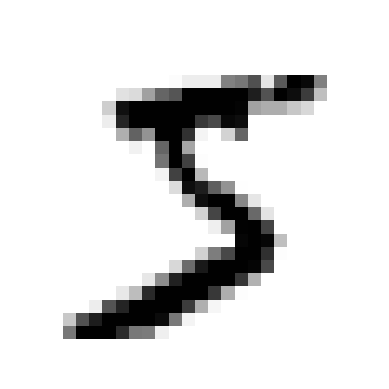

In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28) #28 by 28로 이미지 생성
  plt.imshow(image, cmap='binary')
  plt.axis('off')

some_digit = x[0]
plot_digit(some_digit)
plt.show()

In [42]:
print(y[0])

5

In [4]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

이진 분류기 테스트. 5는 True, 그외는 False

Stocastic Gradient Descent 분류기로 테스트 해보기

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([some_digit])

array([ True])

아까 그림, some_digit, x[0] 에 대해 5가 맞다고 예측함

## 3.3 성능 측정

3.3.1 교차 검증을 사용한 정확도 측정

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

k-폴드 교차검증
테스트 셋을 3개의 폴드로 나누어서 교차 검증을 실행
각 폴드에 대해, 95% 96% 96%의 정확도를 얻음

In [9]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(x_train, y_train_5)
print(any(dummy_clf.predict(x_train)))
print(cross_val_score(dummy_clf, x_train, y_train_5, cv=3, scoring='accuracy'))

False
[0.90965 0.90965 0.90965]


더미 분류기(가장 많이 등장하는 클래스로 분류) = 5가 아닌 클래스로 분류
정확도가 각각 90.9% 90.6% 90.9%

무조건 5 아님으로만 예측해도 정확도가 90%나 나온다는 의미
분류기 성능의 측정 지표로서 정확도를 사용하지 않는 이유

3.3.2 오차행렬

A B 클래스 쌍에 대해
A가 B로 분류된 횟수를 가늠하는것

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


(0.1)은 1종 오류(귀무가설이 참일때, 채택하지 않음)
(1,0)은 2종 오류(귀무가설이 거짓일때, 채택함)

오차 행렬보다 요약된 지표가 필요할 때는 정밀도를 사용

정밀도 = 예측 중 진짜 참 비율 (참을 많이 고르는거)

재현율 = 진짜 참 중 예측한 비율 (참일 확률을 높이는거)

3.3.3 정밀도와 재현율

In [12]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


정밀도와 재현율의 조화 평균으로 F1 score를 만듦

In [13]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


하지만 정밀도가 더 중요한 경우와 재현율이 더 중요한 경우가 다름
trade off

3.3.4 정밀도/재현율 trade-off

결정 임계값으로 조정 가능

임계값이 높아지면 정밀도가 높아지고

임계값이 낮아지면 재현율이 높아진다

In [14]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function") #예측 결과가 아닌, 결정점수를 반환

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

적절한 임계값 찾기

cross_val_predict로 train의 모든 샘플의 점수를 구하고

precision_recall_curve로 모든 임계값에 대해 정밀도와 재현율 계산

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

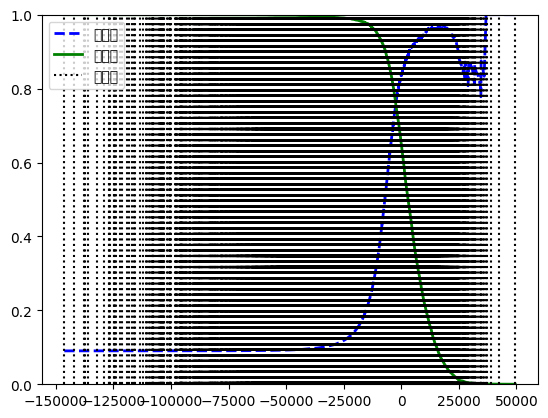

In [15]:
plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='재현율', linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="임계값")
plt.legend(loc='best')
plt.ylim([0,1])
plt.show()

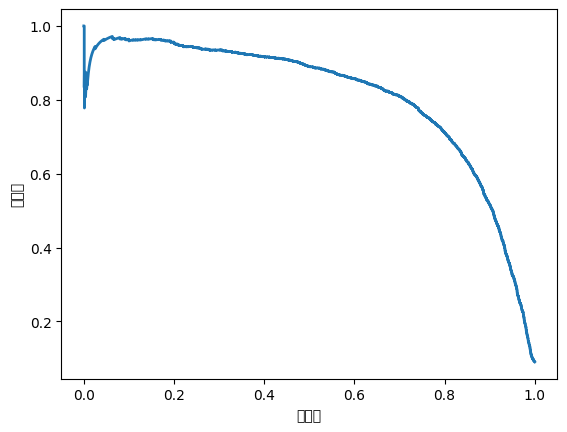

In [16]:
plt.plot(recalls, precisions, linewidth=2, label='정밀도/재현율')
plt.xlabel('재현율')
plt.ylabel('정밀도')
plt.show()

In [17]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

3370.0194991439557


In [18]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

print(precision_score(y_train_5, y_train_pred_90))


0.9000345901072293


정밀도 90%의 분류기를 만드는 데에 성공!

3.3.5 ROC곡선

receiver operation characteristic 곡선

거짓 양성 비율에 대한 진짜 양성 비율 = 1 - 진짜 음성 비율(specificity)

양성 클래스가 드물거나, 거짓 음성보다 거짓 양성이 더 중요할때 정밀도/재현율 곡선을

그 외에는 ROC 곡선을 사용함

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

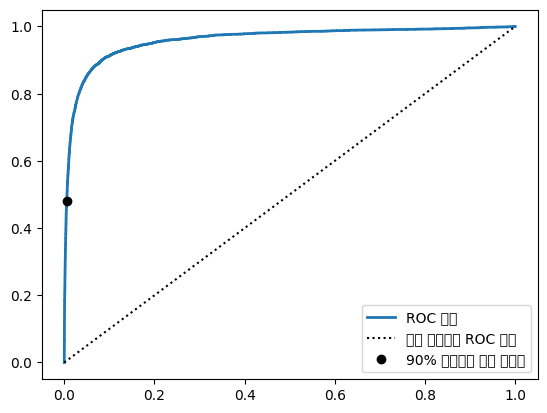

In [20]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label='ROC 곡선')
plt.plot([0,1], [0,1], 'k:', label='랜덤 분류기의 ROC 곡선')
plt.plot([fpr_90], [tpr_90], 'ko', label='90% 정밀도에 대한 임곗값')
plt.legend(loc='best')
plt.show()

Area Under the Curve를 구해서

분류기들을 비교할 수 있음

완벽할 수록 1에 가깝고, 랜덤일수롣 0.5에 가까움

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

random forest classifier를 만들어 stochastic gradient descent classifier와 비교해보기

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

print(y_probas_forest[:2])

[[0.11 0.89]
 [0.99 0.01]]


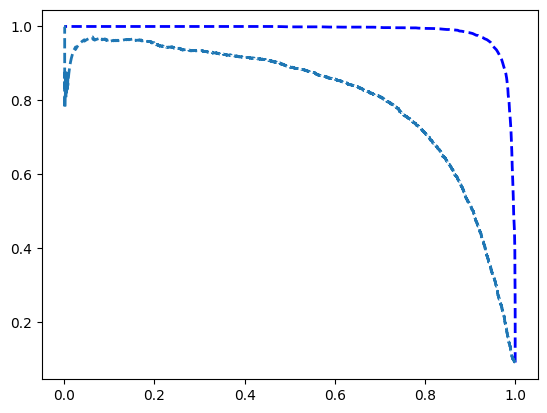

In [23]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b--",linewidth=2, label='랜덤 포레스트')
plt.plot(recalls, precisions, "--", linewidth=2, label='SGD')

랜덤 포레스트가 더 우수해보임

In [24]:
y_train_pred_forest = y_probas_forest[:,1] >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9274509803921569
0.9983436731328145


f1 score와 roc auc도 랜덤 포레스트가 더 우수함

##3.4 다중분류

두개의 클래스를 구분하는 이진분류기가 아닌 다중 분류기로 여러 개의 클래스를 구별 가능함

로지스틱 회귀, 랜덤포레스트, 가우시안 등은 여러 클래스를 직접 처리할 수 있지만,

SGD, SVC 등은 이진 분류만 가능함

다만, 이진 분류기를 여러개 사용하여 다중 분류하는 것도 가능함

0~9에 대해 각각의 분류기를 쓰고 하나를 선택하는 방식을 OvR 혹은 OvA라고 한다.

0vs1 0vs2 ... 해서 총 n(n-1)/2개의 분류기를 쓰는 OvO 방식도 있음.


In [25]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(x_train[:2000], y_train[:2000])

SVC(random_state=42)

In [26]:
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [27]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores.round(2))

[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]


In [28]:
class_id = some_digit_scores.argmax()
print(class_id)

5


In [29]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(x_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [30]:
ovr_clf.predict([some_digit])

array([5], dtype=int8)

In [31]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [32]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

5가 아닌 3. 잘못된 예측이므로 마찬가지로 다중 분류기를 사용해보자

In [33]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

일단 정확도 자체는 모든 폴드에서 85.8 이상이므로 나쁘진 않은 듯 한데 더 올려야 할듯

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype("float64"))
cross_val_score(sgd_clf,x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

개선 완료.

##3.5 오류 분석

모델의 성능을 향상시키는 방법 중 하나는 오류를 분석하는 것

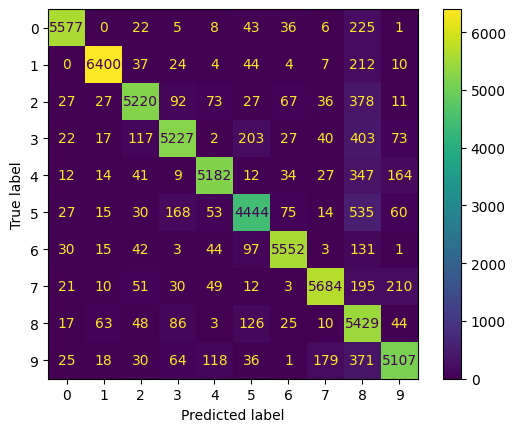

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

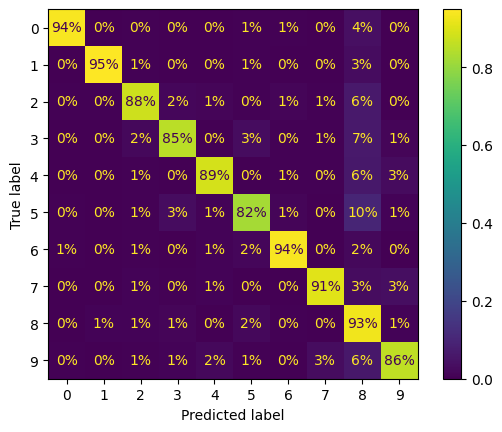

In [36]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')
plt.show()

정규화해서 살펴보니, 5에 대한 적중률은 82%가 고작이고

그중 5를 8로 오인한 경우가 10%나 되는 것을 확인

이를 바탕으로 OpenCV등을 이용하여 이미지의 전처리를 하는 식으로 인사이트를 얻을 수 있음

##3.6 다중 레이블 분류

지금까지는 한 샘플에 대해 하나의 클래스가 할당되는 경우였음

하지만 한 샘플에 대해 여러 개의 클래스를 출력해야 할 수 있음

이를테면 원핫인코딩과 유사한 경우

In [37]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train.astype("int8") % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

큰 값인지(7이상) 여부와 홀수인지 여부도 레이블로 추가되었다

In [38]:
knn_clf.predict([some_digit])

array([[False,  True]])

5는 7보다 작고, 홀수이다

다중 레이블의 평가는 여러 형태가 있겠지만, 그중 하나는

각 레이블에 대해 f1 score을 구하고 평균내는 것이다

In [39]:
y_train_knn_pred = cross_val_predict(knn_clf,x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

물론, 레이블마다 가중치를 둘 수도 있다.

타겟 레이블에 속한 샘플의 개수(지지도, support)에 따라 가중치를 줄 수 있음

average="weighted"

SVC와 같이 다중 레이블 분류를 지원하지 않는 경우 할 수 있는 방식중 하나는

레이블 당 하나의 모델을 학습시키는 것임

레이블 간의 의존성을 놓칠 수 있다는 단점이 있지만

모델을 chain으로 구성하여 해결

In [40]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(x_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [41]:
chain_clf.predict([some_digit])

array([[0., 1.]])

##3.7 다중 출력 분류

다중 레이블 분류에서 하나 더 나아가, 한 레이블이 다중 클래스가 될 수 있도록(?)